In [ ]:
import tensorflow as tf
IMG_HEIGHT= 224
IMG_WIDTH= 224
IMG_CHANNELS=3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [ ]:
def read_and_decode(filename, resize_dims):
  # 1. Read the raw file
  img_bytes= tf.io.read_file(filename)
  # 2. Decode image data
  img= tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
  # 3. Convert image to float values in [0, 1]
  img= tf.image.convert_image_dtype(img, tf.float32)
  # 4. Resize the image to the match the desire dimention
  img= tf.image.resize(img, resize_dims)
  return img


In [ ]:
def parse_csvline(csv_line):
  # print("csv line:", csv_line)
  # record_defaults specify the data types for each columns
  record_default = ["", ""]
  filename, label_string =tf.io.decode_csv(csv_line, record_defaults=record_default)


  #load the image
  img= read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  # print("Label String:",label_string)
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

#This csv file conatains the path of the image and its corresponding label, It is stored on the Google Cloud Storage

In [ ]:
!gsutil cat gs://cloud-ml-data/img/flower_photos/train_set.csv | wc -l

3300


In [ ]:
#Define dataset
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    #.map(parse_csvline) # it will process one by one line to the map function which is slow
    #.map(parse_csvline, num_parallel_calls=4) # it will process one by four line to the map function which is faster

    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE) # It will adjust the number of line to the function depends upon the cpu
    .batch(16)
    .prefetch(tf.data.AUTOTUNE)
)
test_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(16)
    .prefetch(tf.data.AUTOTUNE) # When the model is training the current batch then it will prepare the next batch in the background.
)

In [ ]:
count=0
for _ in train_dataset:
  count+=1
print(count)

207


In [ ]:
for image_batch, label_batch in train_dataset.take(3):
  print("Image Batch Shape: ", image_batch.shape)
  print("Label Batch Shape: ", label_batch.shape)
  print("Labels:", label_batch.numpy())




Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [0 1 1 1 0 2 1 0 4 3 0 3 1 4 4 1]
Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [0 3 2 1 0 4 2 0 2 2 1 3 3 2 1 0]
Image Batch Shape:  (16, 224, 224, 3)
Label Batch Shape:  (16,)
Labels: [3 1 1 1 1 0 1 2 4 3 3 2 0 1 4 0]


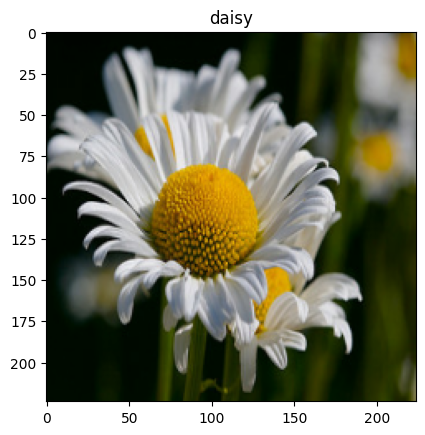

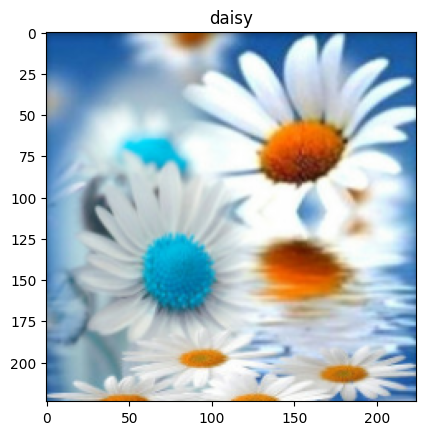

In [ ]:
import matplotlib.pyplot as plt
for image_batch, label_batch in train_dataset.take(2):
  first_image=image_batch[0].numpy()
  first_label=label_batch[0].numpy()
  plt.imshow(first_image)
  plt.title(CLASS_NAMES[first_label])
  plt.show()


#Model Architecture

In [ ]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │       752,645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 752,645 (2.87 MB)

 Trainable params: 752,645 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
Epoch=10
history=model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=Epoch
)

Epoch 1/10
      3/Unknown 3s 579ms/step - accuracy: 0.2292 - loss: 21.4011

KeyboardInterrupt: 

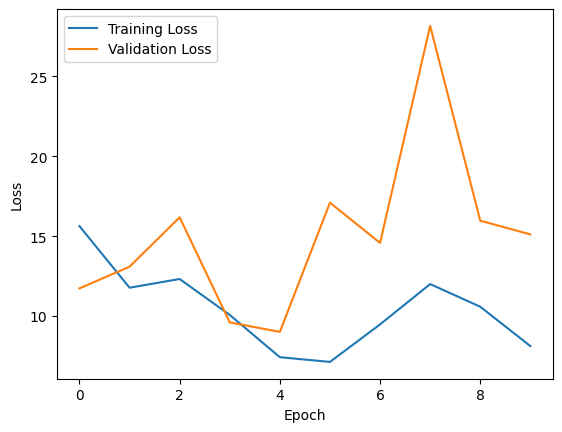

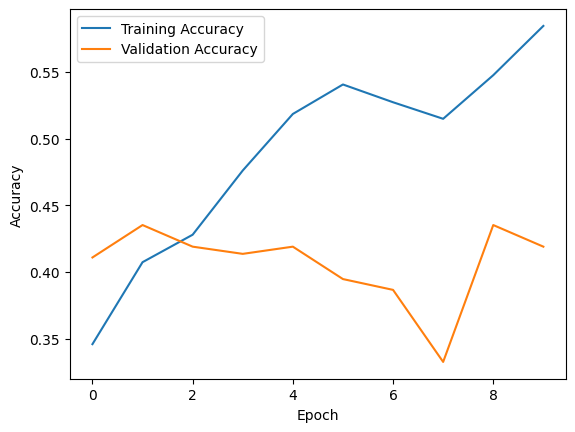

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


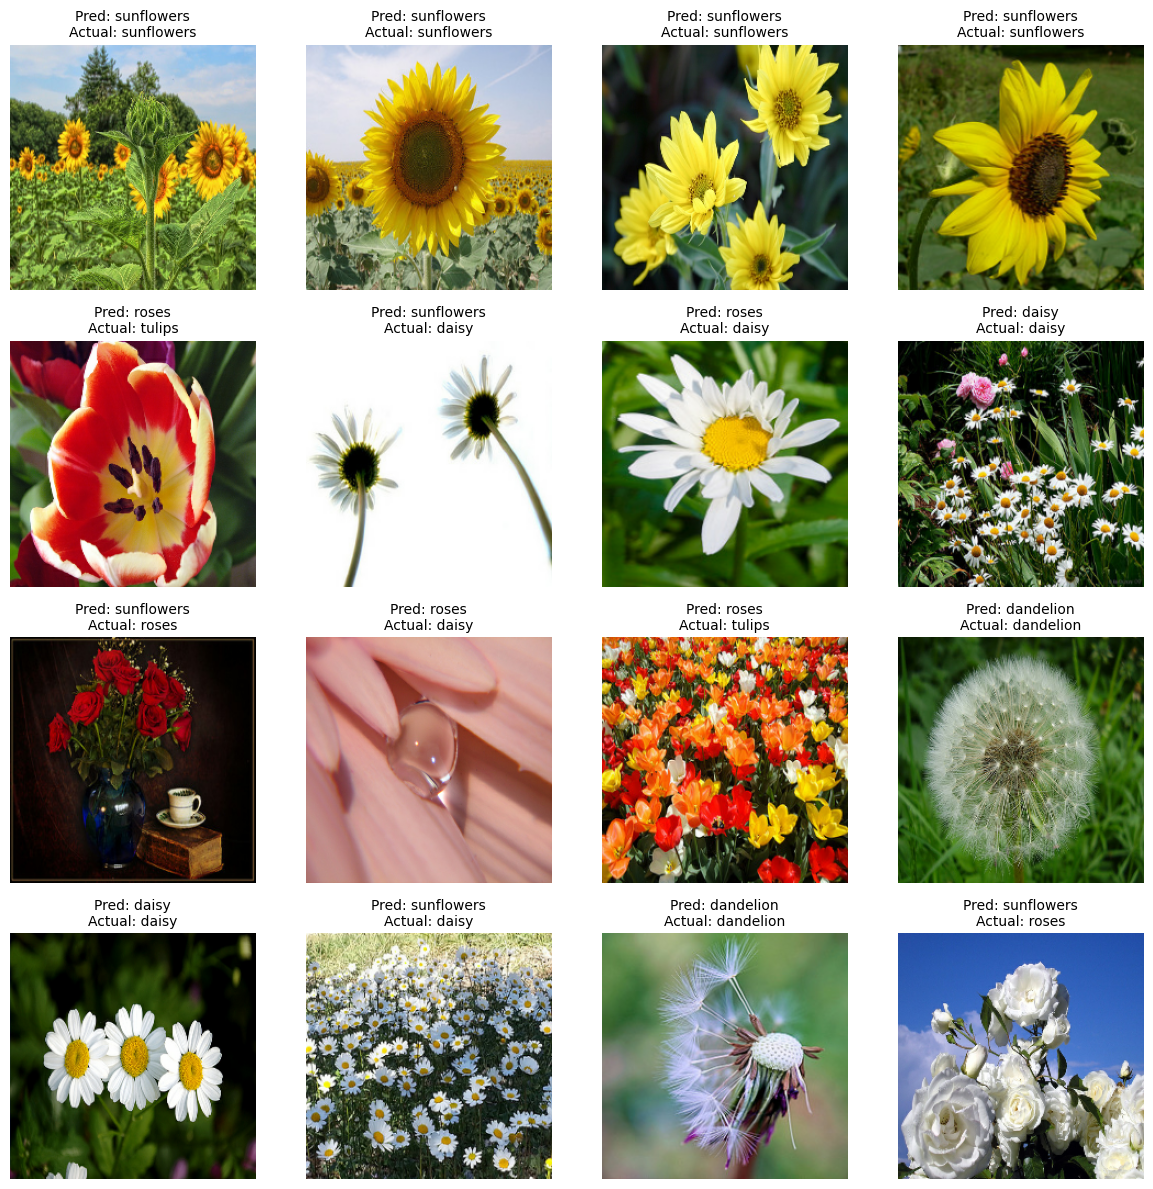

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in test_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()